## SLAM Demonstation using FastSLAM algorithm
### by Melbourne Space Program 


### Acknowledgement

We acknoledge that the code below is primarily adopted from the Python Robotics Repo at https://github.com/AtsushiSakai/PythonRobotics#fastslam-10

by Kaif Ashan, Kenneth Huynh and Peter Shi from the Melbourne Space Program.




### Introduction

FastSlam is variation of SLAM which uses Particle filters, a.k.a Sequential Monte Carlo, to solve the SLAM problem. It uses a feature based maps or occupancy grids

### Overview of the Algorithm: 

There are three main stages of the FastSLAM Algorithm. Initially, a certain number of particles are drawn from a uniform distribution to represent the initial uncertainty regarding the location of the rover in the map. Then the following three steps help approxiamate the exact location of the rover. 

>##### 1. Predict the pose: 
In this step we predict a state where the rover is based on the vehicle control (u) and the motion model. These samples are known as particles and they hold an estimate of the rover's pose. Each of the particles have a weight associated with them which in the beginning is equal for all.
>##### 2. Update particles weights: 
Then the particls are updated using observations z. We mainly update the weights of each particle based on how likely the particle to have the correct ose given the sensor measurement. 
>##### 3. Resample: 
Resampling is done to filter out the particles with the largest weights. Can be thought like survival of the fittest and the unlikely ones with lowest weights die out. 

### Simulation 
In the simulation below we have mimiced the observation made by sensors and added noise to the vehicle control which will be present in real life. 

The picture below is a snapshot of the program. Here: 

- The blue line is the true trajectory
- The red line is the estimated trajectory
- The red dots represent the distribution of particles
- The black line represent dead reckoning tracjectory
- The blue x is the observed and estimated landmarks
- The black x is the true landmark


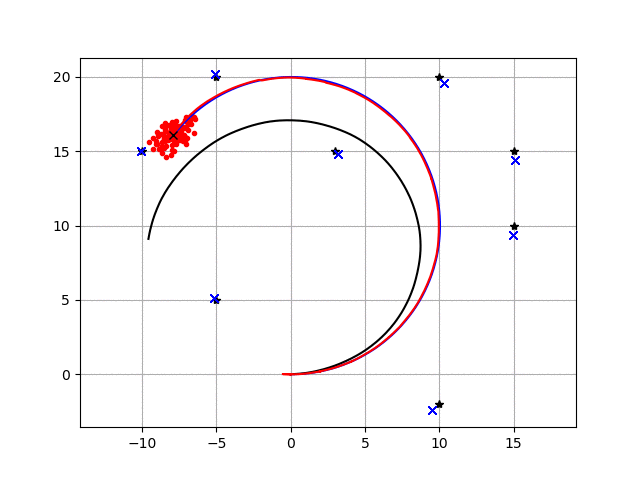

In [7]:
from IPython.display import Image
Image("img/fslam_animation.png", width =600)

### Predicting Particles using the Motion Model

A class which represents all the particles generated by the particle filter. In FastSLAM usually a set of particles are generated through a model which later are updated by cross-checking with observastions made through sensors/know data.

In [1]:
class Particle:

    def __init__(self, N_LM):
        # * As the number of particles increase their weights decrease
        self.w = 1.0 / N_PARTICLE
        self.x = 0.0
        self.y = 0.0
        self.yaw = 0.0
        # landmark x-y positions
        self.lm = np.zeros((N_LM, LM_SIZE))
        # landmark position covariance
        self.lmP = np.zeros((N_LM * LM_SIZE, LM_SIZE))

The following equations and code snippets we can see how the particles distribution evolves in case we provide only the control $(v,w)$, which are the linear and angular velocity repsectively.

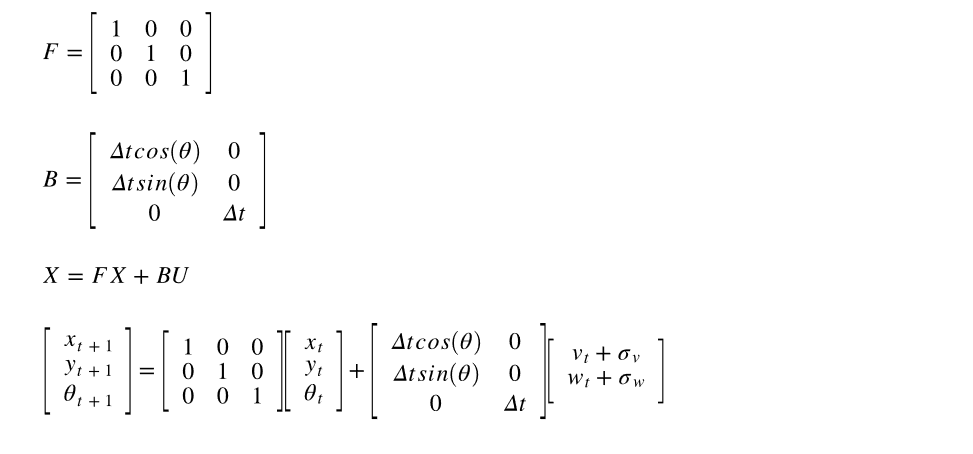

In [4]:
from IPython.display import Image
Image("img/motion_model.png", width = 700)

In [3]:
def motion_model(x, u):
    # The state matrix 
    # In the demo only an identity matrix 
    F = np.array([[1.0, 0, 0],
                  [0, 1.0, 0],
                  [0, 0, 1.0]])

    # Input matrix
    B = np.array([[DT * math.cos(x[2, 0]), 0],
                  [DT * math.sin(x[2, 0]), 0],
                  [0.0, DT]])

    # Update the position of the rover based on the controls 
    # * Doesn't adjust for any noise
    x = F @ x + B @ u

    # Convert the angle into the first quadrant 
    x[2, 0] = pi_2_pi(x[2, 0])

    return x

def pi_2_pi(angle):
    return (angle + math.pi) % (2 * math.pi) - math.pi

In [4]:
def predict_particles(particles, u):

    # For each particle produce a new sample
    for i in range(N_PARTICLE):
        px = np.zeros((STATE_SIZE, 1))
        px[0, 0] = particles[i].x
        px[1, 0] = particles[i].y
        px[2, 0] = particles[i].yaw
        # adding noise to the original control
        ud = u + (np.random.randn(1, 2) @ R ** 0.5).T
        # Run the state of particles and the noisy controls through the motion model  
        px = motion_model(px, ud)
        # Update the new state of the particles 
        particles[i].x = px[0, 0]
        particles[i].y = px[1, 0]
        particles[i].yaw = px[2, 0]

    return particles

In [5]:
###################### update_with_observation ###################### 

Description to be added by Peter

In [ ]:
def update_with_observation(particles, z):
    for iz in range(len(z[0, :])):

        lmid = int(z[2, iz])

        for ip in range(N_PARTICLE):
            # new landmark
            if abs(particles[ip].lm[lmid, 0]) <= 0.01:
                particles[ip] = add_new_lm(particles[ip], z[:, iz], Q)
            # known landmark
            else:
                w = compute_weight(particles[ip], z[:, iz], Q)
                particles[ip].w *= w
                particles[ip] = update_landmark(particles[ip], z[:, iz], Q)

    return particles


Description to be added by Peter

In [ ]:
def add_new_lm(particle, z, Q_cov):
    r = z[0]
    b = z[1]
    lm_id = int(z[2])

    s = math.sin(pi_2_pi(particle.yaw + b))
    c = math.cos(pi_2_pi(particle.yaw + b))

    particle.lm[lm_id, 0] = particle.x + r * c
    particle.lm[lm_id, 1] = particle.y + r * s

    # covariance
    Gz = np.array([[c, -r * s],
                   [s, r * c]])

    particle.lmP[2 * lm_id:2 * lm_id + 2] = Gz @ Q_cov @ Gz.T

    return particle

Description to be added by Peter

In [ ]:
def compute_weight(particle, z, Q_cov):
    lm_id = int(z[2])
    xf = np.array(particle.lm[lm_id, :]).reshape(2, 1)
    Pf = np.array(particle.lmP[2 * lm_id:2 * lm_id + 2])
    zp, Hv, Hf, Sf = compute_jacobians(particle, xf, Pf, Q_cov)

    dx = z[0:2].reshape(2, 1) - zp
    dx[1, 0] = pi_2_pi(dx[1, 0])

    try:
        invS = np.linalg.inv(Sf)
    except np.linalg.linalg.LinAlgError:
        print("singuler")
        return 1.0

    num = math.exp(-0.5 * dx.T @ invS @ dx)
    den = 2.0 * math.pi * math.sqrt(np.linalg.det(Sf))

    w = num / den

    return w

Description to be added by Peter

In [ ]:
def update_landmark(particle, z, Q_cov):
    lm_id = int(z[2])
    xf = np.array(particle.lm[lm_id, :]).reshape(2, 1)
    Pf = np.array(particle.lmP[2 * lm_id:2 * lm_id + 2, :])

    zp, Hv, Hf, Sf = compute_jacobians(particle, xf, Pf, Q)

    dz = z[0:2].reshape(2, 1) - zp
    dz[1, 0] = pi_2_pi(dz[1, 0])

    xf, Pf = update_kf_with_cholesky(xf, Pf, dz, Q_cov, Hf)

    particle.lm[lm_id, :] = xf.T
    particle.lmP[2 * lm_id:2 * lm_id + 2, :] = Pf

    return particle

In [ ]:
###################### resampling ###################### 